In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/35.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/31.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/33.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/14.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/20.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/18.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/21.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/12.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/28.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/22.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/34.png
/kaggle/in

In [2]:
import numpy as np

import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.models import densenet121
np.random.seed(42)
torch.manual_seed(42)

In [2]:
num_classes = len(os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'))

In [3]:
# Custom Dataset Class


class LiverDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, _, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = class_names.index(label)  # Convert label to index
        return image, label_idx

# Get Class Names from Train Directory
class_names = os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train')


In [4]:
train_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'
training_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            training_data.append([image_path, patient, label])

In [5]:
test_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
testing_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            testing_data.append([image_path, patient, label])



In [6]:
valid_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
validation_data = []

for label in os.listdir(valid_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        valid_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            validation_data.append([image_path, patient, label])

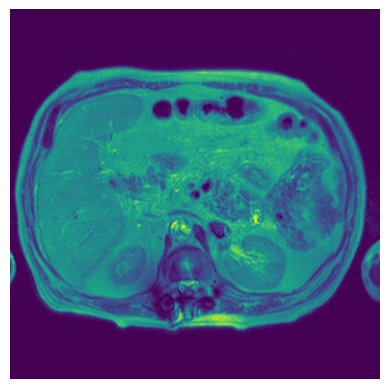

In [7]:
image_path = training_data[0][0]
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [8]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomRotation(degrees=5),  # Rotate image by ±5 degrees
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [9]:
train_dataset = LiverDiseaseDataset(training_data, transform=data_transforms['train'])
val_dataset = LiverDiseaseDataset(validation_data, transform=data_transforms['val'])
test_dataset = LiverDiseaseDataset(testing_data, transform=data_transforms['test'])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
class MSCA(nn.Module):
    def __init__(self, in_channels):
        super(MSCA, self).__init__()

        self.conv5x5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2, groups=in_channels)

        self.conv7x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(7, 1), padding=(3, 0), groups=in_channels)
        self.conv1x7 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 7), padding=(0, 3), groups=in_channels)

        self.conv5x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(5, 1), padding=(2, 0), groups=in_channels)
        self.conv1x5 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 5), padding=(0, 2), groups=in_channels)

        self.conv3x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(3, 1), padding=(1, 0), groups=in_channels)
        self.conv1x3 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 3), padding=(0, 1), groups=in_channels)

        self.channel_mixing = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        conv5x5 = self.conv5x5(x)

        conv1x7 = self.conv1x7(conv5x5)
        conv7x1 = self.conv7x1(conv1x7)

        conv1x3 = self.conv1x3(conv5x5)
        conv3x1 = self.conv3x1(conv1x3)

        conv1x5 = self.conv1x5(conv5x5)
        conv5x1 = self.conv5x1(conv1x5)

        multi_scale = conv5x5 + conv7x1 + conv5x1 + conv3x1

        mixed = self.channel_mixing(multi_scale)
        return mixed * x


In [4]:
class MSCANStage(nn.Module):
    def __init__(self, in_channels):
        super(MSCANStage, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.attention = MSCA(in_channels)
        self.norm2 = nn.BatchNorm2d(in_channels)
        self.ffn = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=1)
        )
    
    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


In [5]:
# class MSCAN_DenseNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(MSCAN_DenseNet, self).__init__()
#         self.densenet = densenet121(pretrained=True)
#         self.densenet=nn.Sequential(*list(densenet121.features.children())[:-1])
#         self.mscan_stage = MSCANStage(in_channels=1024)  # DenseNet-121 has 1024 channels before classifier
#         self.classifier = nn.Linear(1024, num_classes)
    
#     def forward(self, x):
#         features = self.densenet.features(x)
#         features = self.mscan_stage(features)
#         out = F.adaptive_avg_pool2d(features, (1, 1))
#         out = torch.flatten(out, 1)
#         out = self.classifier(out)
#         return out 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import densenet121, DenseNet121_Weights


class MSCAN_DenseNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MSCAN_DenseNet, self).__init__()
        
        # Load DenseNet-121 without classifier
        weights = DenseNet121_Weights.DEFAULT
        densenet = densenet121(weights=weights)
        
        # Remove classifier by using only the feature extractor
        self.backbone = densenet.features  # this excludes the classifier

        # Add your custom MSCAN stage
        self.mscan_stage = MSCANStage(in_channels=1024)  # Make sure this is correct

        # Replace classifier
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.backbone(x)  # Feature maps from DenseNet
        x = self.mscan_stage(x)  # Your custom stage
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global avg pool
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
model = MSCAN_DenseNet(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


MSCAN_DenseNet(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [7]:
model = model.to(device)

# Calculate and print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Total Trainable Parameters: {total_params}")

✅ Total Trainable Parameters: 10173315


Epoch 1 | train Loss: 0.5688, Acc: 0.7468
Epoch 1 | val Loss: 3.9639, Acc: 0.5161
Epoch 2 | train Loss: 0.1843, Acc: 0.9282
Epoch 2 | val Loss: 3.9931, Acc: 0.5161
Epoch 3 | train Loss: 0.1149, Acc: 0.9556
Epoch 3 | val Loss: 4.4724, Acc: 0.5161
Epoch 4 | train Loss: 0.0796, Acc: 0.9718
Epoch 4 | val Loss: 4.7978, Acc: 0.5161
Epoch 5 | train Loss: 0.0459, Acc: 0.9846
Epoch 5 | val Loss: 6.1835, Acc: 0.4782
Epoch 6 | train Loss: 0.0308, Acc: 0.9895
Epoch 6 | val Loss: 6.5509, Acc: 0.5161
Epoch 7 | train Loss: 0.0124, Acc: 0.9968
Epoch 7 | val Loss: 7.1423, Acc: 0.5161
Epoch 8 | train Loss: 0.0085, Acc: 0.9983
Epoch 8 | val Loss: 6.6843, Acc: 0.4972
Epoch 9 | train Loss: 0.0074, Acc: 0.9983
Epoch 9 | val Loss: 7.2516, Acc: 0.5161
Epoch 10 | train Loss: 0.0064, Acc: 0.9987
Epoch 10 | val Loss: 6.6257, Acc: 0.5161
Epoch 11 | train Loss: 0.0071, Acc: 0.9991
Epoch 11 | val Loss: 6.7081, Acc: 0.5161
Epoch 12 | train Loss: 0.0061, Acc: 0.9992
Epoch 12 | val Loss: 7.6892, Acc: 0.5161
Epoch 13 |

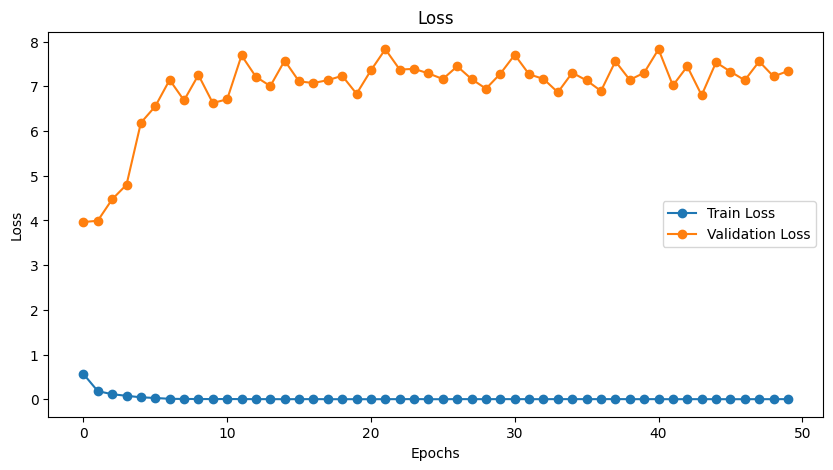

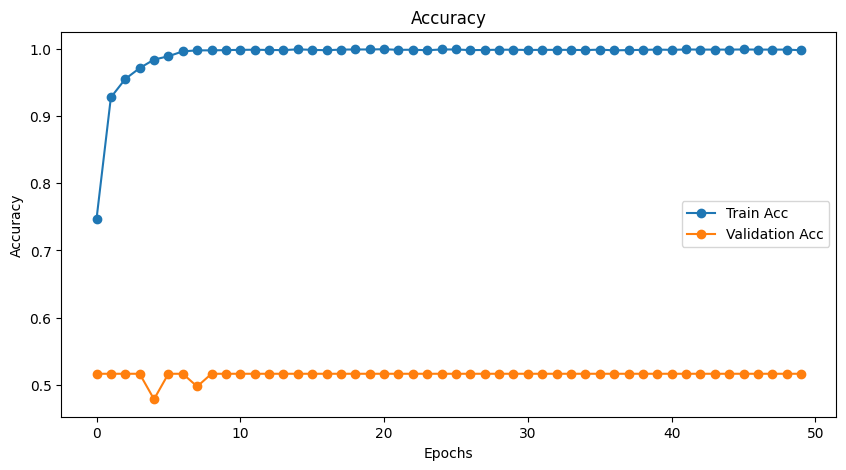

In [15]:
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Add a learning rate scheduler (StepLR with step size of 5 epochs and gamma=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 50
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss, correct = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    
    # Step the scheduler after each epoch
    scheduler.step()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss'), plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy'), plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), "densenet121_model.pth")
print("Model saved successfully!")

Model saved successfully!


Test Accuracy: 58.73%

Class-wise Metrics:
2:
  Precision: 0.20
  Recall: 0.33
  F1-Score: 0.25
  Specificity: 0.66
3:
  Precision: 0.66
  Recall: 0.57
  F1-Score: 0.62
  Specificity: 0.89
1:
  Precision: 0.85
  Recall: 0.69
  F1-Score: 0.76
  Specificity: 0.86

Overall Metrics:
  Precision: 0.57
  Recall: 0.53
  F1-Score: 0.54
  Specificity: 0.81

Classification Report:
              precision    recall  f1-score   support

           2       0.20      0.33      0.25       133
           3       0.66      0.57      0.62       181
           1       0.85      0.69      0.76       350

    accuracy                           0.59       664
   macro avg       0.57      0.53      0.54       664
weighted avg       0.67      0.59      0.62       664



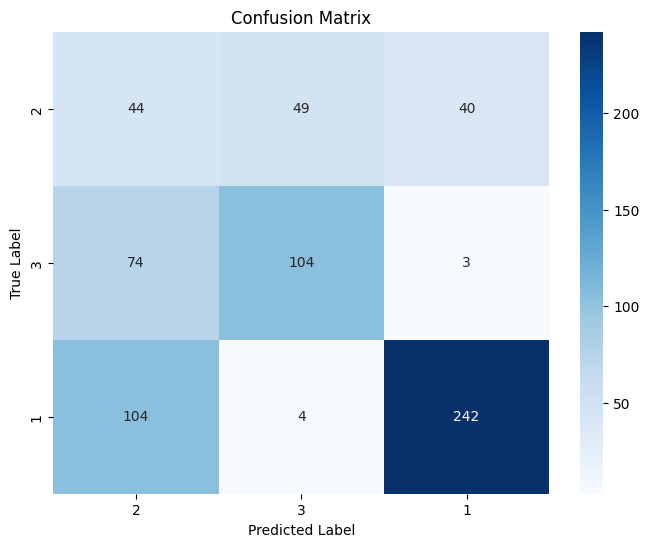

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
)

# Ensure model is in evaluation mode
model.eval()

# Store true and predicted labels
y_true = []
y_pred = []

# Run model on test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Use your test data loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute class-wise precision, recall, f1-score, and support
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Compute specificity for each class
specificity = []
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True Negatives
    fp = cm[:, i].sum() - cm[i, i]  # False Positives
    specificity.append(tn / (tn + fp))

# Compute overall precision, recall, and f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# Compute overall specificity
overall_specificity = np.mean(specificity)

# Display class-wise metrics
print("\nClass-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Specificity: {specificity[i]:.2f}")

# Print overall metrics
print("\nOverall Metrics:")
print(f"  Precision: {overall_precision:.2f}")
print(f"  Recall: {overall_recall:.2f}")
print(f"  F1-Score: {overall_f1:.2f}")
print(f"  Specificity: {overall_specificity:.2f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [2]:
import torch
import torchvision.models as models

# Load DenseNet-121
model = models.densenet121(pretrained=True)

# Print model to identify the layer
# print(model)  # Optional: to see architecture

# Register a forward hook to the classifier input
def hook_fn(module, input, output):
    print("Shape before fully connected layer:", input[0].shape)

hook = model.classifier.register_forward_hook(hook_fn)

# Create dummy input (batch_size=1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224)

# Forward pass
with torch.no_grad():
    _ = model(dummy_input)

# Remove the hook if needed
hook.remove()


Shape before fully connected layer: torch.Size([1, 1024])


In [3]:
model = models.densenet121(pretrained=True)

In [5]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu